# Tutorial 8b: Extracting data from images

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This exercise was generated from a Jupyter notebook.  You can download the notebook [here](t8b_extracting_data_from_images.ipynb).*

In [1]:
import glob
import os

import numpy as np
import pandas as pd
import scipy.signal

# Image processing tools
import skimage
import skimage.io

import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

# Import Bokeh modules for interactive plotting
import bokeh
bokeh.io.output_notebook()

Loading BokehJS ...

Before we can start working with images, we need to know how to do all of the more mundane things with them, like organizing, loading, storing, etc.  Images that you want to analyze come is all sorts of formats and are organized in many different ways.  One instrument may give you a TIFF stack consisting of 8-bit images.  Another may give you a directory with lots of images in it with different names.  And so many instruments give you data in some proprietary format.  You need to know how to deal with lots of file formats and organization.

In this course, we will analyze various images, including microscopy images.  I generally will give them to you in exactly the format I received them in.

In today's tutorial, we will use a data set from three class alumni (Mike Abrams, Claire Bedbrook, and Ravi Nath) in the class to practice loading images, defining ROIs, and some basic skills for extracting information from images.

In this tutorial and throughout the class, we will use `scikit-image` to do almost all of our image processing.  It has continual development, with new features constantly being added.  For the fairly simple image processing we'll do in this course, it suffices for most of what we need.  The [course website](http://bebi103.caltech.edu/2016/links.html) has links to many other image processing toolkits, some Python-based and many not.  In particular, [OpenCV](http://opencv.org) is very powerful and has complete Python bindings, though not yet for the newest version 3.1.

## The data set

The data set comes from three Caltech graduate students, Mike Abrams, Claire Bedbrook, and Ravi Nath, who are working on studying day and night behavior in jellyfish.  They photograph jellyfish over time and study their pulsing behavior.  A typical image is shown below.

<img src="jellyfish.png">

A single jellyfish lives in each box.  The boxes are 4 by 4 inches.  The jellyfish constantly contract and relax in a pulsing motion.  Our task today is to get traces so we can measure pulse frequency.

We have two different data sets, day and night, each contained in their own directory.  Each image they acquired is stored as a TIFF image.  The frame rate was 15 frames per second.

Let's take a look at the structure of the directory with the images.  We will use the `glob` module, which allows us to specify string with wild cards to specify files of interest.

In [2]:
# The directory containing daytime data
data_dir = '../data/Cassiopea_Pulsation/day'

# Glob string for images
im_glob = os.path.join(data_dir, '*.TIF')

# Get list of files in directory
im_list = glob.glob(im_glob)

# Let's look at the first 10 entries
im_list[:10]

['../data/Cassiopea_Pulsation/day/Frame_545000.TIF',
 '../data/Cassiopea_Pulsation/day/Frame_545001.TIF',
 '../data/Cassiopea_Pulsation/day/Frame_545002.TIF',
 '../data/Cassiopea_Pulsation/day/Frame_545003.TIF',
 '../data/Cassiopea_Pulsation/day/Frame_545004.TIF',
 '../data/Cassiopea_Pulsation/day/Frame_545005.TIF',
 '../data/Cassiopea_Pulsation/day/Frame_545006.TIF',
 '../data/Cassiopea_Pulsation/day/Frame_545007.TIF',
 '../data/Cassiopea_Pulsation/day/Frame_545008.TIF',
 '../data/Cassiopea_Pulsation/day/Frame_545009.TIF']

We see that the images are nicely named so that successive frames are stored in order.  This is convenient, and when this is not the case, you should rename files so that when listed in alphabetical order, they also appear in temporal order.

## Loading and displaying images

The workhorse for much of our image processing is `scikit-image`.  We will load our first image using `scikit-image`.  When importing `scikit-image`, it is called `skimage`, and we need to import the submodules individually.  The submodule for reading and writing images is `skimage.io`.  We can use it to load and display an image.  Let's start with the first jellyfish image.

In [3]:
# Read in the image using skimage
im = skimage.io.imread(im_list[0])

# Let's get information about the image
print(type(im), im.dtype, im.shape)

<class 'numpy.ndarray'> uint16 (480, 640, 3)


So, the image is stored as a NumPy array of 16-bit `int`s.  The array is 3$\times$480$\times$640, which means this is an RGB image.  The first index of the image indicates the channel (red, green, or blue).  Cameras often store black and white images as RGB, so let's see if all three channels are the same.

In [4]:
# Test to see if each R, G, and B value is the same
((im[:,:,0] == im[:,:,1]) &  (im[:,:,1] == im[:,:,2])).all()

True

Indeed they are, so we can just consider one of the channels in our analysis.

In [5]:
# Just slice the red channel
im = im[:,:,0]

Now, let's use `skimage.io.imshow()` to take a look at the image.

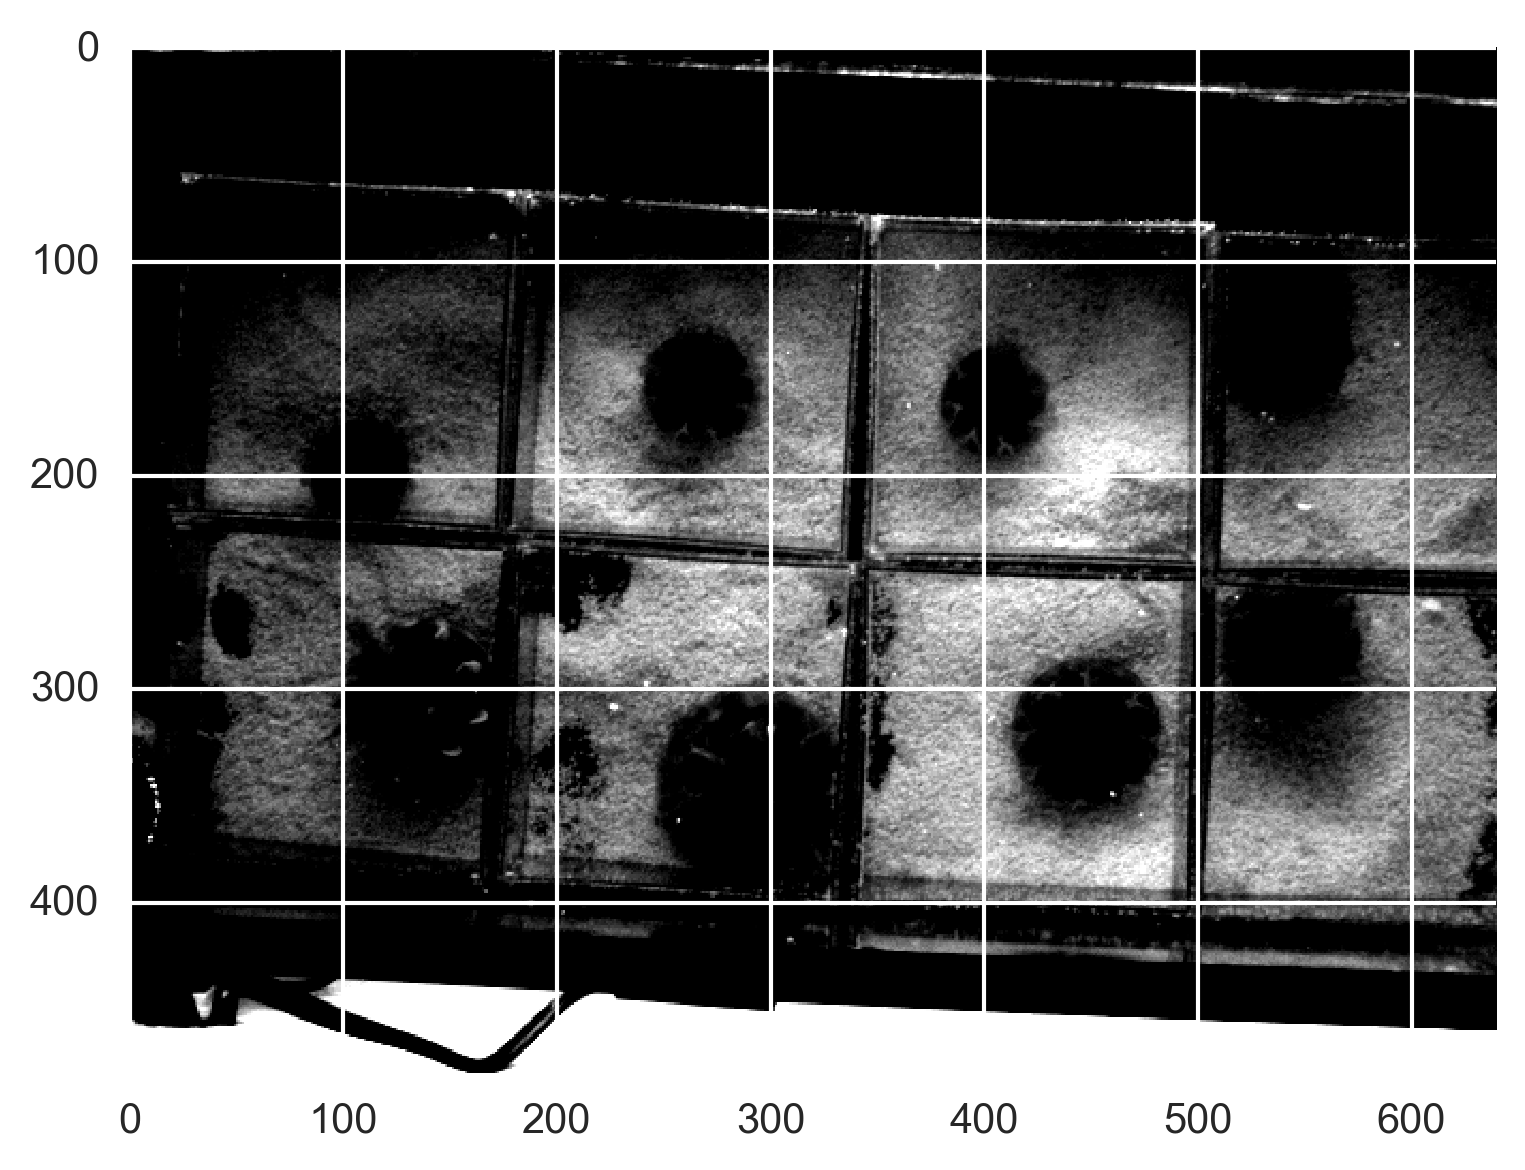

In [6]:
skimage.io.imshow(im);

To avoid the white gridlines (which we may or may not want), we can temporarily change Seaborn's axis style in a `with` block.

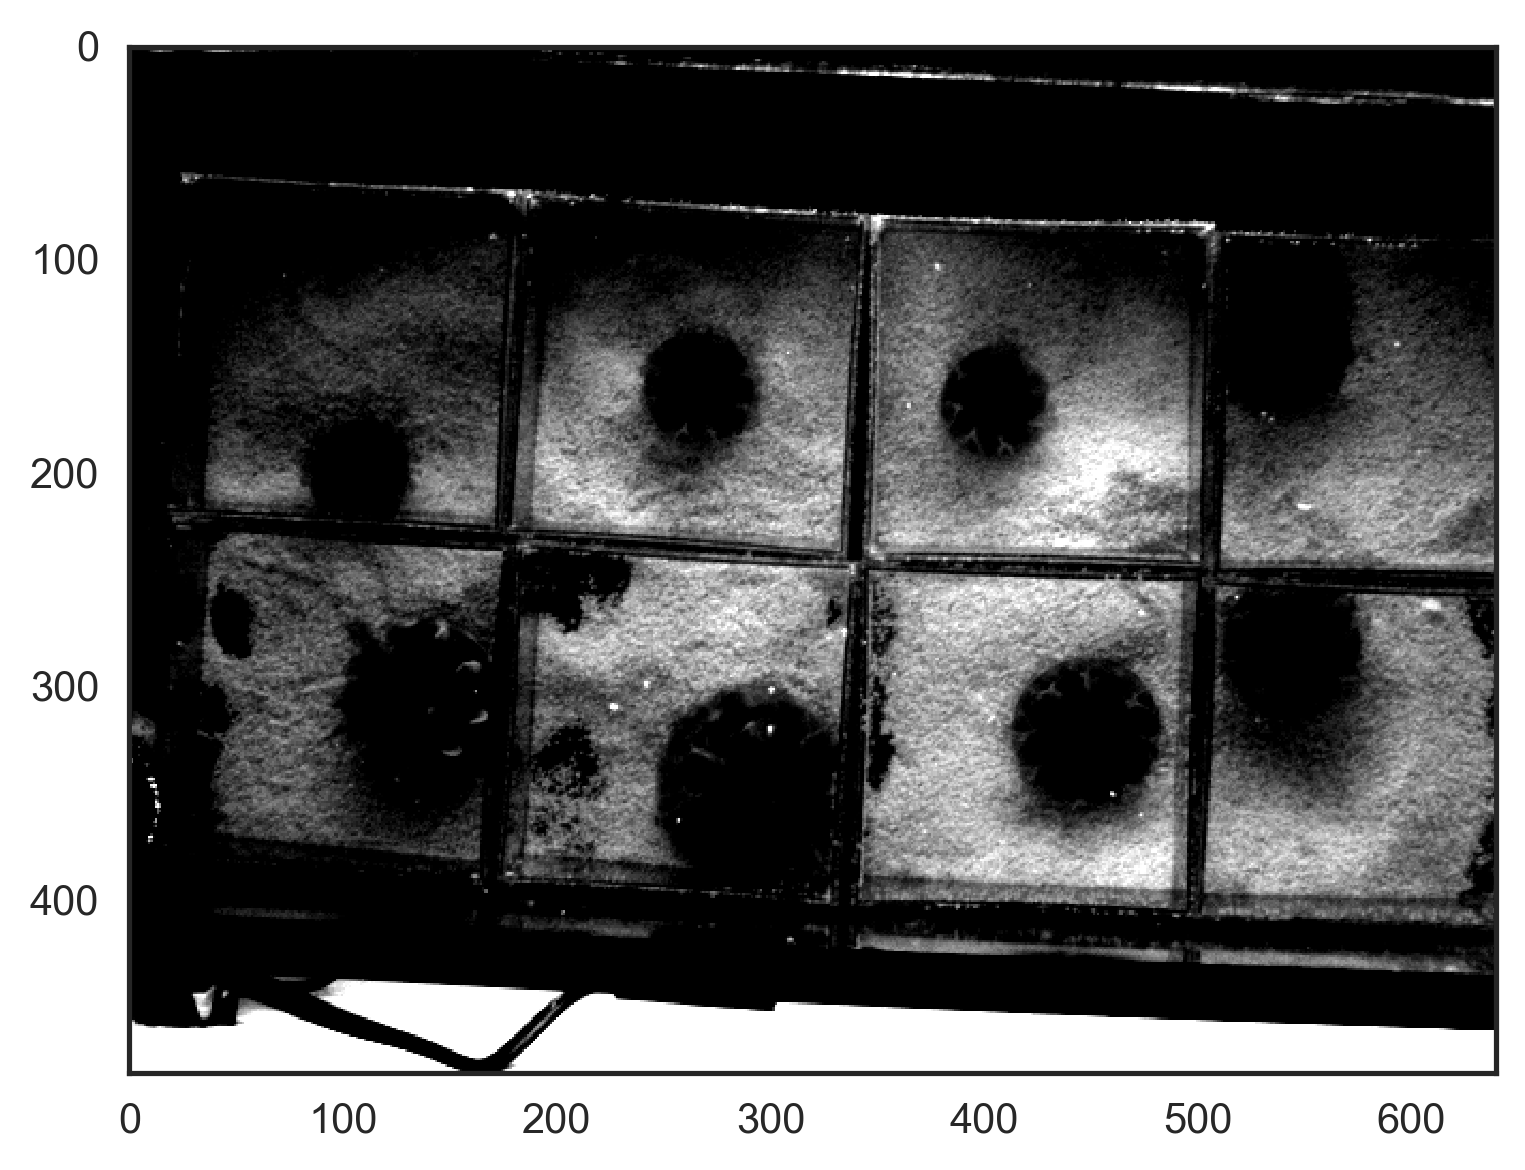

In [7]:
with sns.axes_style('white'):
    skimage.io.imshow(im)

## Burning a scale bar

Remember, scientific images are not just pretty pictures. It is crucially important that you know the interpixel distance and that the images have a scale bar when displayed, at least for publication.

For some microscope set-ups, we already know the physical length corresponding to the interpixel distance.  We often take a picture of something with known dimension (such as a stage micrometer) to find the interpixel distance.  In the case of these jellyfish images, we know the boxes are 4$\times$4 inches.  We can get the locations of the boxes in units of pixels using the `plt.ginput()` function.  This function records the coordinates of mouse clicks on a figure.  If you want to do this with a Jupyter notebook, you need to use the `%matplotlib notebook` magic function, as opposed to the `%matplotlib inline` that we normally use. This enable interactivity with Matplotlib figures. Alternatively, you can use IPython from the terminal and click in a figure window. I did this, I get the following results for the width of a box.

In [8]:
xy = [(346.43976683937819, 246.4948186528498),
      (498.77137305699478, 251.93523316062181)]

We can use these points to compute the length of a side of a box.

In [9]:
box_length = np.sqrt((xy[1][1] - xy[0][1])**2 + (xy[1][0] - xy[0][0])**2)

The interpixel distance is then 4 inches / `box_length`.  We will compute it in centimeters.

In [10]:
interpixel_distance = 4 / box_length * 2.54

Now that we know the interpixel distance, we can burn a scale bar.  To do this, we simply set a stripe of pixels in a black area of the image to be white (or vice versa).  The upper left corner of the image is black and makes for a nice place to put a scale bar.  We will burn a scale bar of 5 cm.

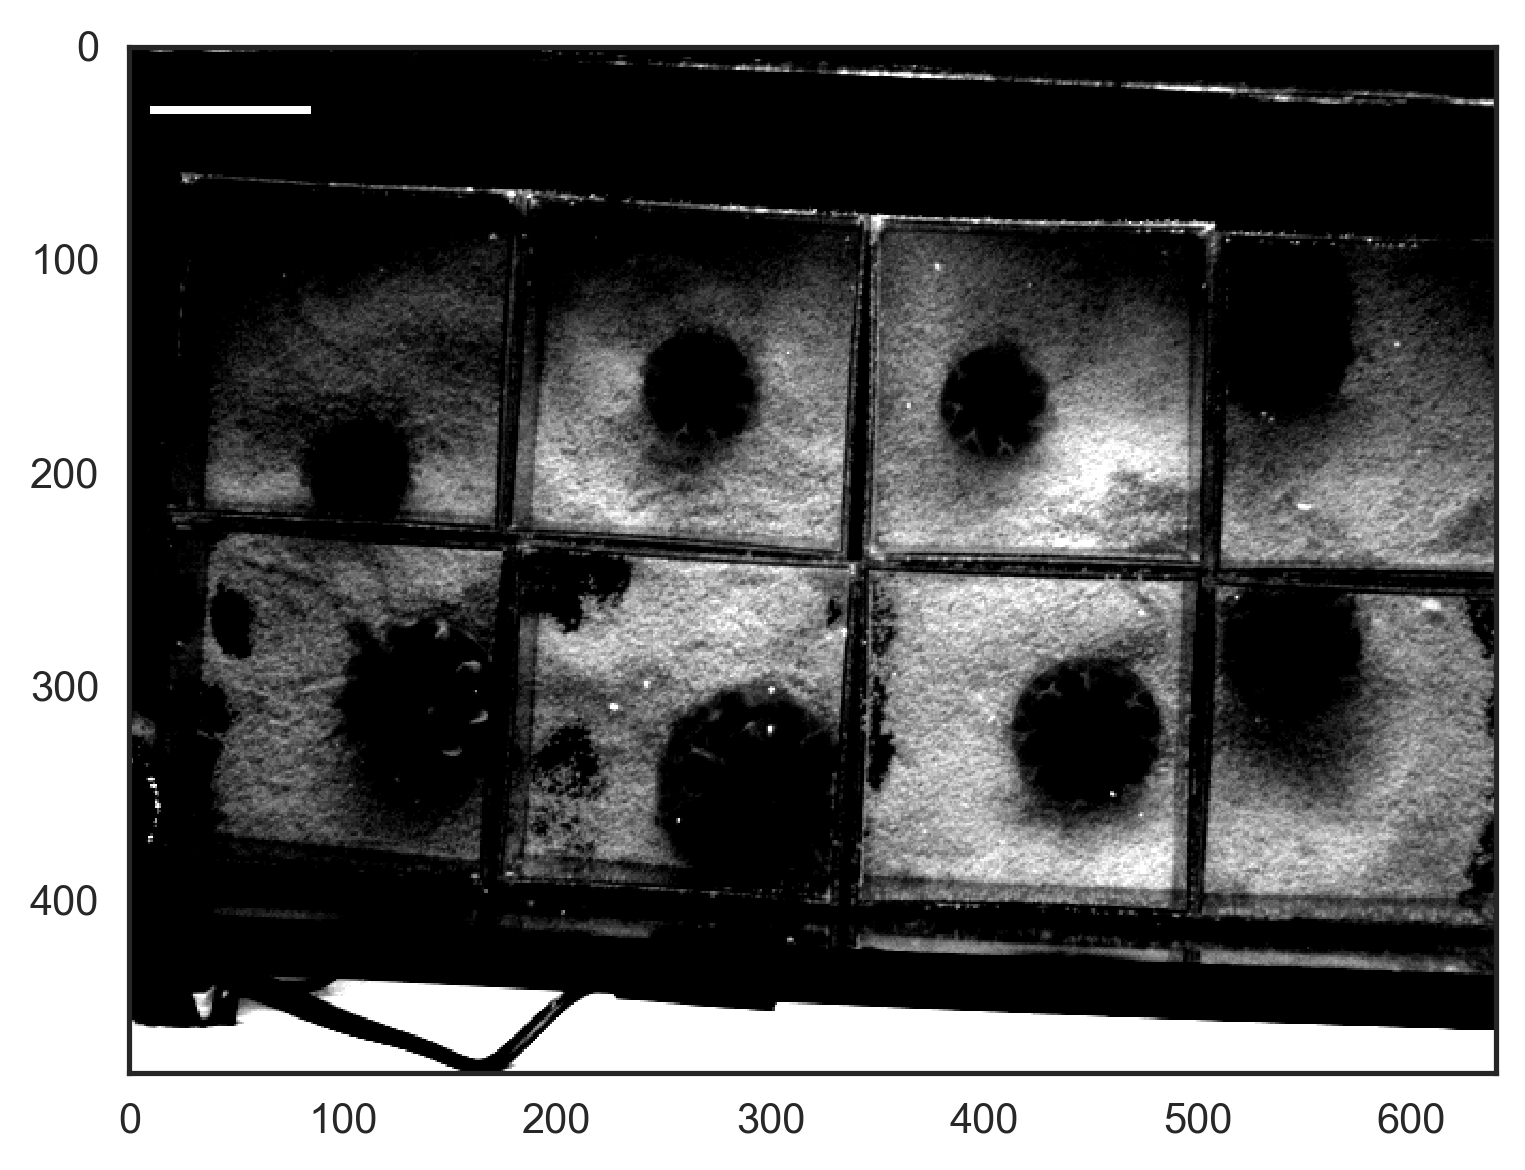

In [11]:
def burn_scale_bar(im, length, i_pos, j_pos, width=4, white=True):
    """
    Burn a horizontal scale bar starting at i_pos, j_pos.
    All units of inputs are interpixel distance.
    """
    im_out = im.copy()
    
    if white:
        pixel_val = skimage.dtype_limits(im)[1]
    else:
        pixel_val = skimage.dtype_limits(im)[0]
    
    im_out[i_pos-(width//2):i_pos+(width//2), j_pos:j_pos+length] = pixel_val
    return im_out
    
# Put black scale bar
im_sb = burn_scale_bar(im, int(5 // interpixel_distance), 30, 10)

# Look at it
with sns.axes_style('white'):
    skimage.io.imshow(im_sb)

Note, though, that in the case of an image like this, we could just put something like, "Jelly fish boxes are 4$\times$4 inches," in our caption, and be done with it.  I'm showing you this because it is important to know how to do for many of the images you come across.

`scikit-image` currently does not have capability to add text.  You can make scale bars with text easily when preparing figures for publication within a Python framework using [OpenCV](http://opencv.org/) or by using [Fiji](http://fiji.sc/).

I want to make a final couple of notes on scale bars.  Some will argue that the scale bars could be added as vector graphics with nice, clean text.  There is no inherent problem with this, but in practice, images often get stretched and rearranged for display in presentations or in publications.  It is often difficult to control how various layers on objects will scale when this is done.  I prefer to keep myself out of trouble and burn in the scale bars.  Finally, make sure your scale bars are not burned in to the image you are actually analyzing, only those for viewing!  Remember, by burning in the scale bar in something you are analyzing, you are changing *data*!

## False coloring for image display

Remember, showing an image on screen or printing it on a piece of paper is *plotting data*.  We are free to choose *how* we plot it.  The common convention is to show the image in gray scale, but we need not do that.  We can instead look at the image in false color.  ("False" is a misnomer here, since any color is just a representation of photon counts on a detector.)  *This is not adding or subtracting information; it is merely changing the way we display it.*  Since images are typically sequential data, sequential colormaps are preferred.  In cases where we might have stark separation between dark and light, a diverging colormap is useful.  My favorite sequential and diverging colormaps for images are, respectively, `plt.cm.viridis` (Matplotlib's fantastic new default colormap) and `plt.cm.RdBu_r`.  Let's look at the image with these colormaps.

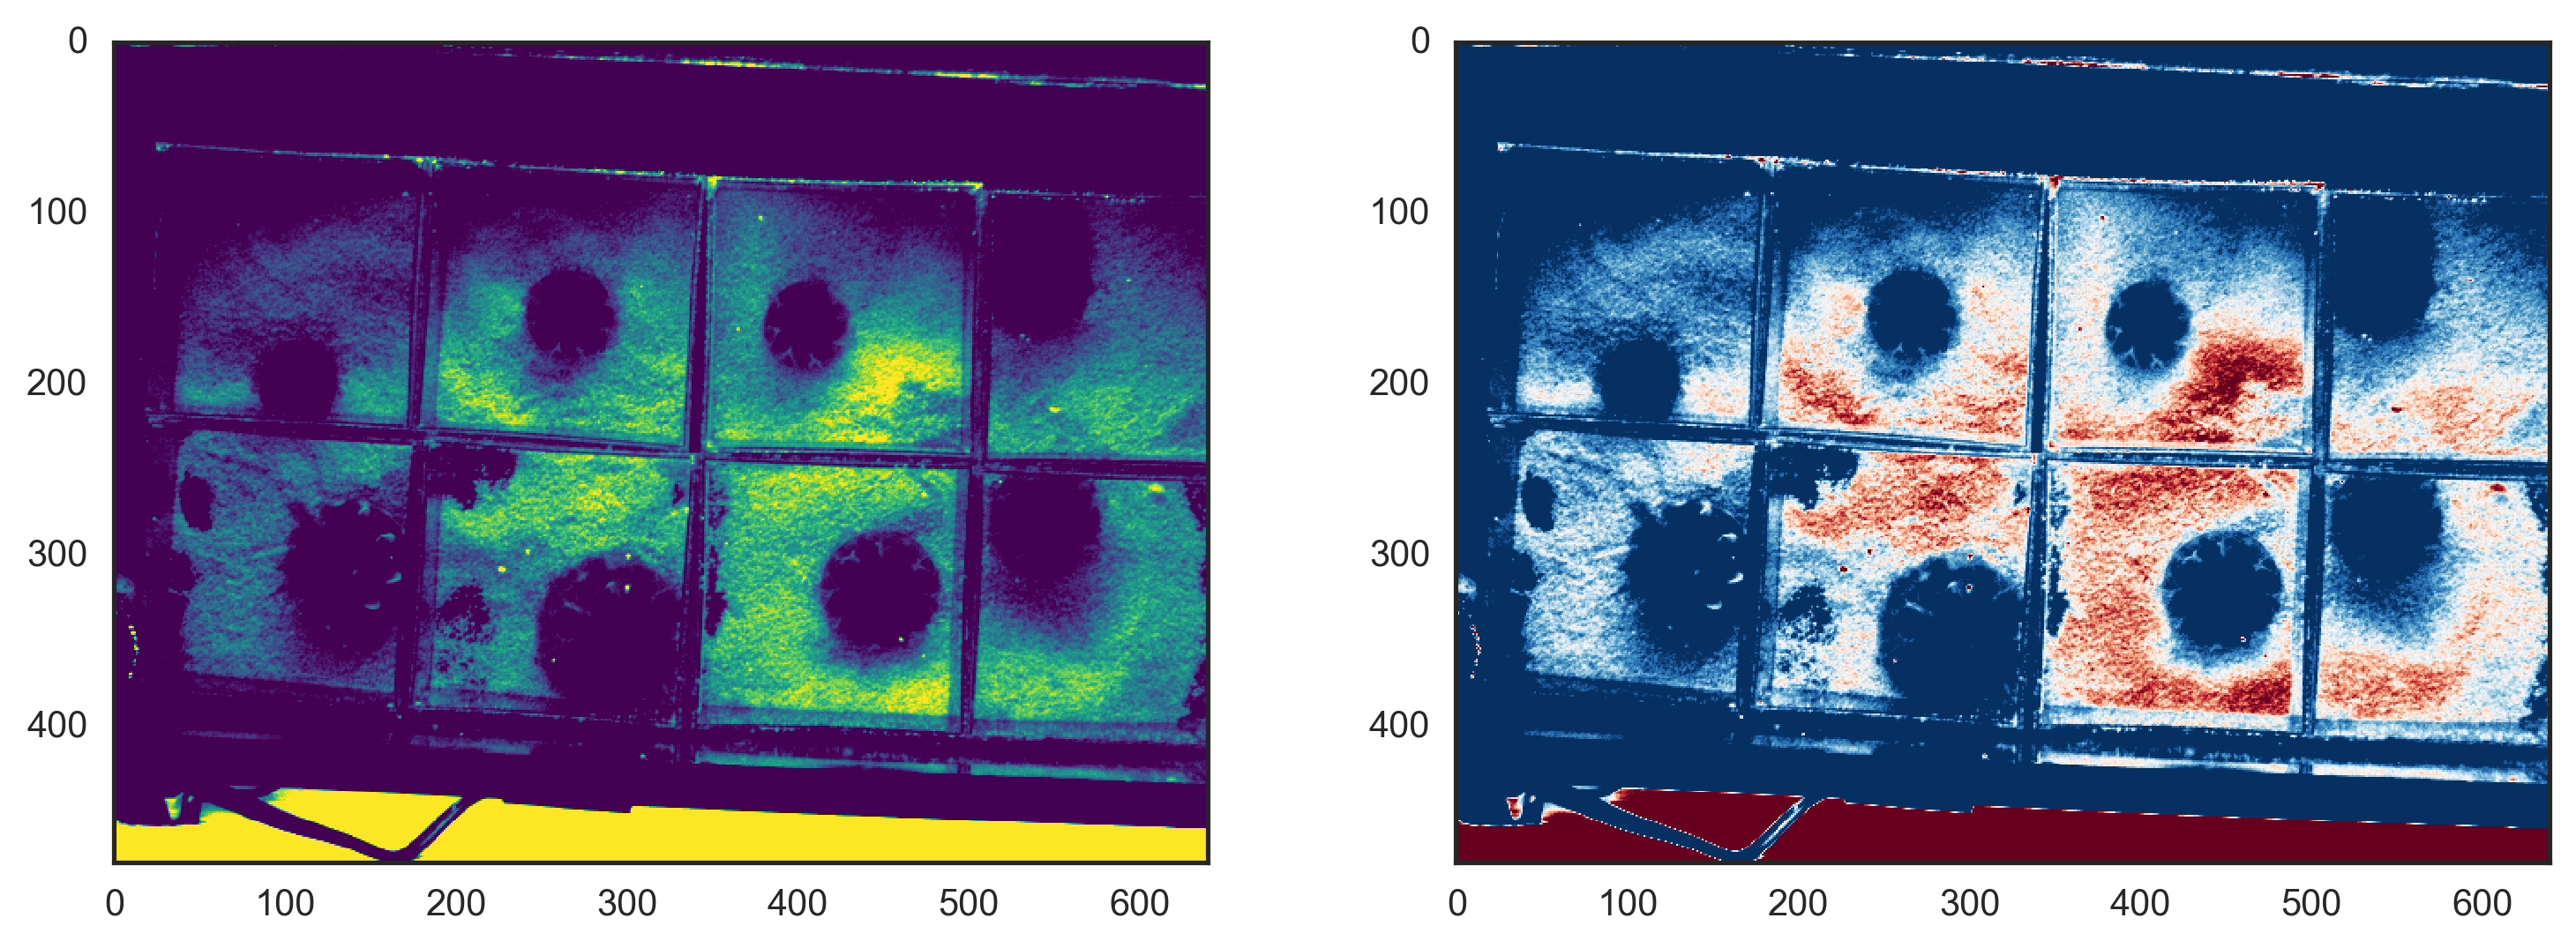

In [12]:
# Set up figure with subplots
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].imshow(im, cmap=plt.cm.viridis)
    ax[1].imshow(im, cmap=plt.cm.RdBu_r)

It is often easier to see fine detail with false coloring.  While not important for our analysis, we can, for example, see the nuances in brightness in the sand on which the jellyfish sit.

## Loading a stack of images

While we have done some nice things with single images, we really want to be able to sequentially look at all of the images of the movie, a.k.a. the stack of images.

`scikit-image` has a convenient way to do this using the `skimage.io.ImageCollection` class.  We simple give it a string matching the pattern of the file names we want to load.  In our case, this is `im_glob` that we have already defined.  An important kwarg is `conserve_memory`.  If there are many images, it is best to select this to be `True`.  For few images, selecting this to be `False` will result in better performance because all of the images will be read into RAM.  Let's load the daytime movie as an `ImageCollection`.  (Note: we're not actually loading them all in; we just creating an object that knows where the images are so we can access them at will.)

In [13]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)

Conveniently, the `ImageCollection` has nice properties.  Typing `len(ic)` tells how many images are in the collection.  `ic[157]` is the 157th image in the collection.  There is one problem, though.  All of the images are read in with all three channels.  We would like to only include one channel, since the others are redundant.  To do this, we can instantiate the `ImageCollection` with the `load_func` kwarg.  This specifies a function that reads in and returns a NumPy array with the image.  The default is `load_func=skimage.io.imread`, but we can write out own.  We'll write a function that loads the image and then just returns the red channel and reinstantiate the `ImageCollection` using that load function.

In [39]:
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)

We should also have time stamps for the data in the images.  We know the frame rate is 15 frames per second, so we can attach times to each image.  Normally, these would be in the metadata of the images and we would fish that out, but for this example, we will just generate our own time points (in units of seconds).

In [40]:
fps = 15
t = np.arange(0, len(ic)) / fps

## Setting an ROI

A **region of interest**, or ROI, is part of an image or image stack that we would like to study, ignoring the rest.  Depending on the images we are analyzing, we may be able to automatically detect ROIs based on well-defined criteria.  Often, though, we need to manually pick regions in an image as our ROI.

`scikit-image` is an open source project that is constantly under development.  It currently does not have a way to specify ROIs, but it is on the list of functionality to be added.

So, I wrote my own ROI utility, which is included in [`bebi103_utils`](https://github.com/justinbois/bebi103_utils).  It takes a set of vertices that define a polygon, the inside of which constitutes a region of interest.  (Note that the polygon cannot have crossing lines.)  It returns a tuple that contains a **mask** for the ROI, a **bounding box**, and the mask for an image consisting entirely of the bounding box.  An ROI mask is the same shape as the image, except where the image has a pixel value, the ROI mask has a `True` value if the pixel is within the ROI and has a `False` value it if is outside.  The bounding box defines the smallest square subimage that completely contains the ROI.  Finally, it is convenient to have a mask that is reindexed such that (0,0) is the upper left corner of the bounding box.

To get the vertices, we can again use the `plt.ginput()` function. The syntax is below, with `ginput()` commented out, with its output instead hard coded. (This is what you should do for your homeworks as well.) In this example, I drew a square in the image to select a single box.

In [41]:
# Select the condos as ROIs.  Use plt.ginput to get vertices
# Uncomment the below to use ginput.  Hit enter when finished selecting verts
# verts = plt.ginput(100)

verts = [(348.79397748093913, 246.73039544685778),
         (491.30157835613034, 249.91294732744518),
         (487.05817584868049, 392.77416507825723),
         (347.37950997845581, 386.76267819270322)]

Now we can use `bebi103.verts_to_roi()` to make make the ROI.

In [42]:
roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, *ic[0].shape)

Now that we have defined the ROI, let's look at it.  We will use a trick where we take a grayscale image, convert it to RGB, and then add more blue in certain regions to highlight.

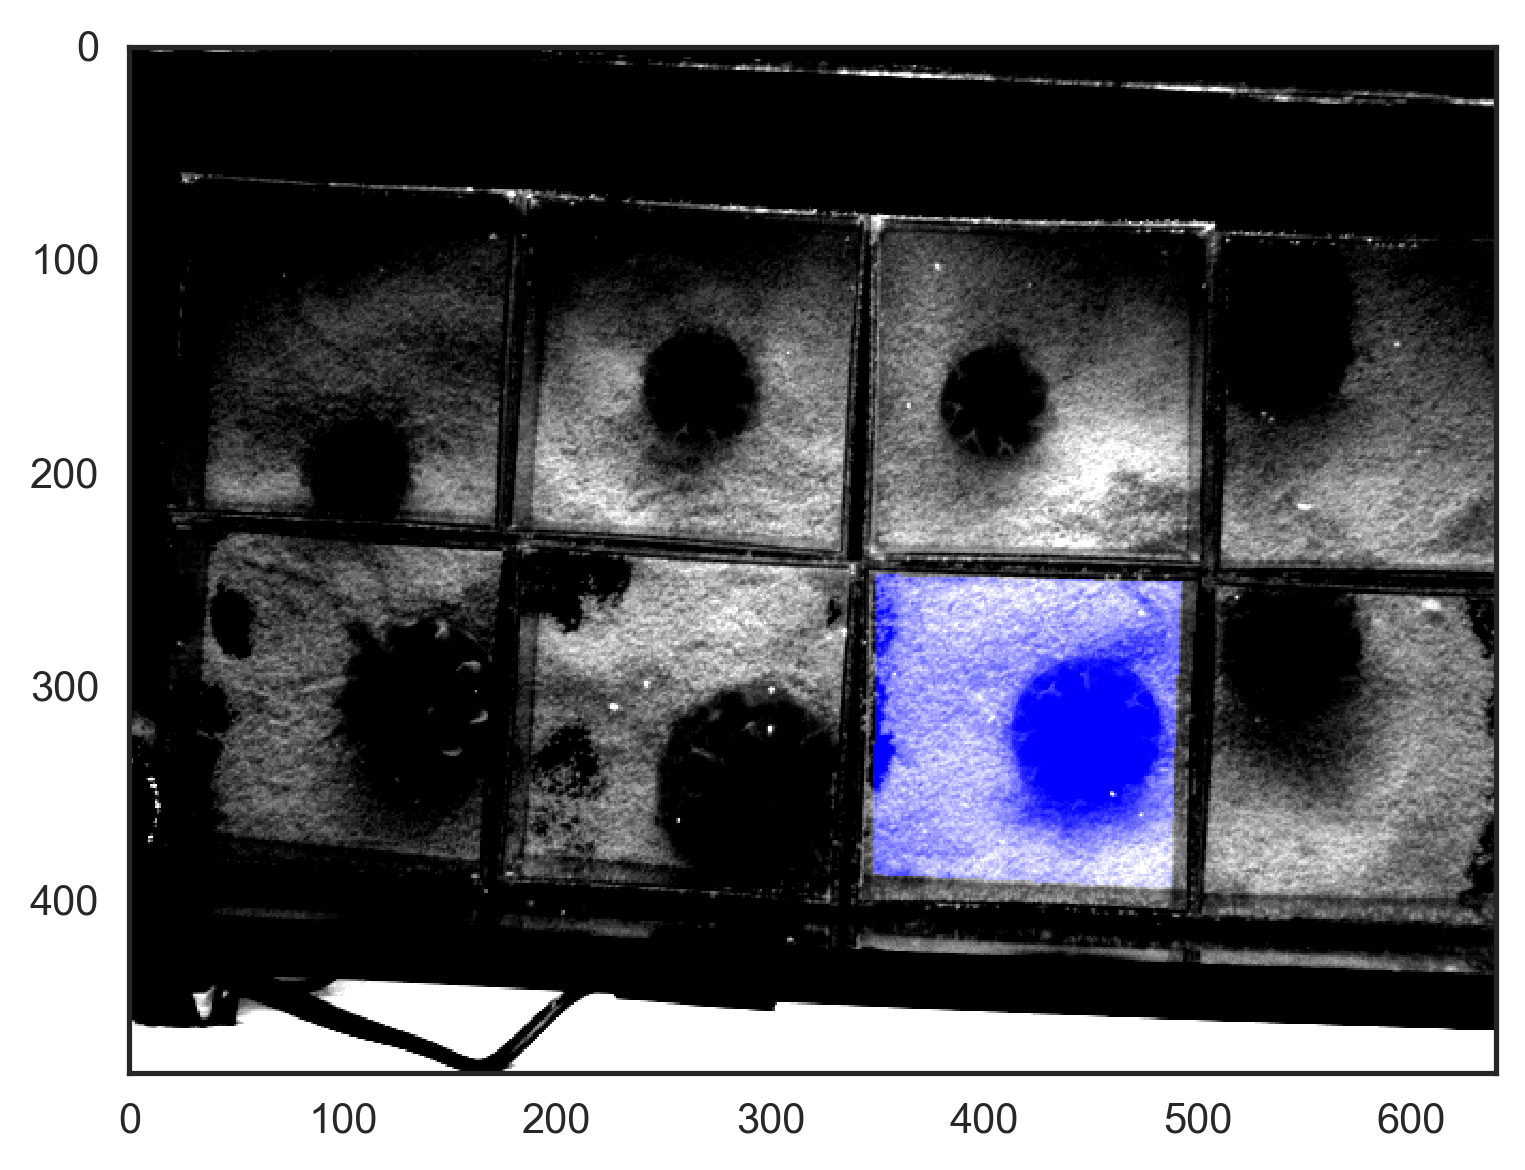

In [43]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

If you just want to look at the region of the image that bounds the ROI, you can do the following.

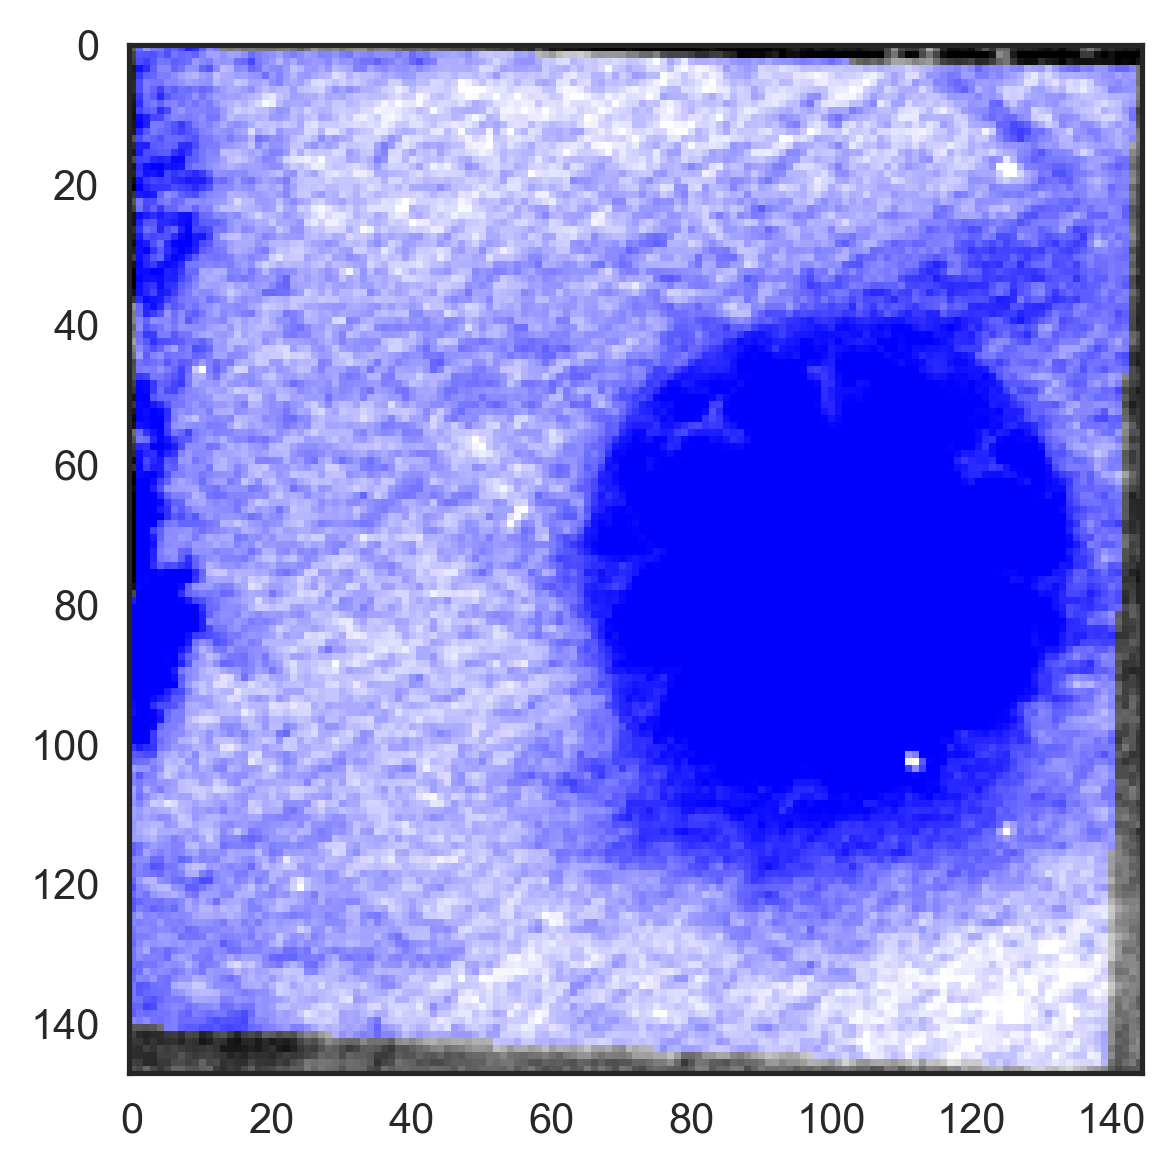

In [44]:
# Get cropped image and ROI within it
im = ic[0][roi_bbox]
im_cropped_roi = roi_box

# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(im)])

# Max out blue channel
im[im_cropped_roi,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

So, when working with ROIs, the `roi`, `roi_bbox`, and `roi_box` are useful tools to automatically index the original image to get what you are interested in.  We could also modify our `load_func` for our `ImageCollection` to just load in an ROI.

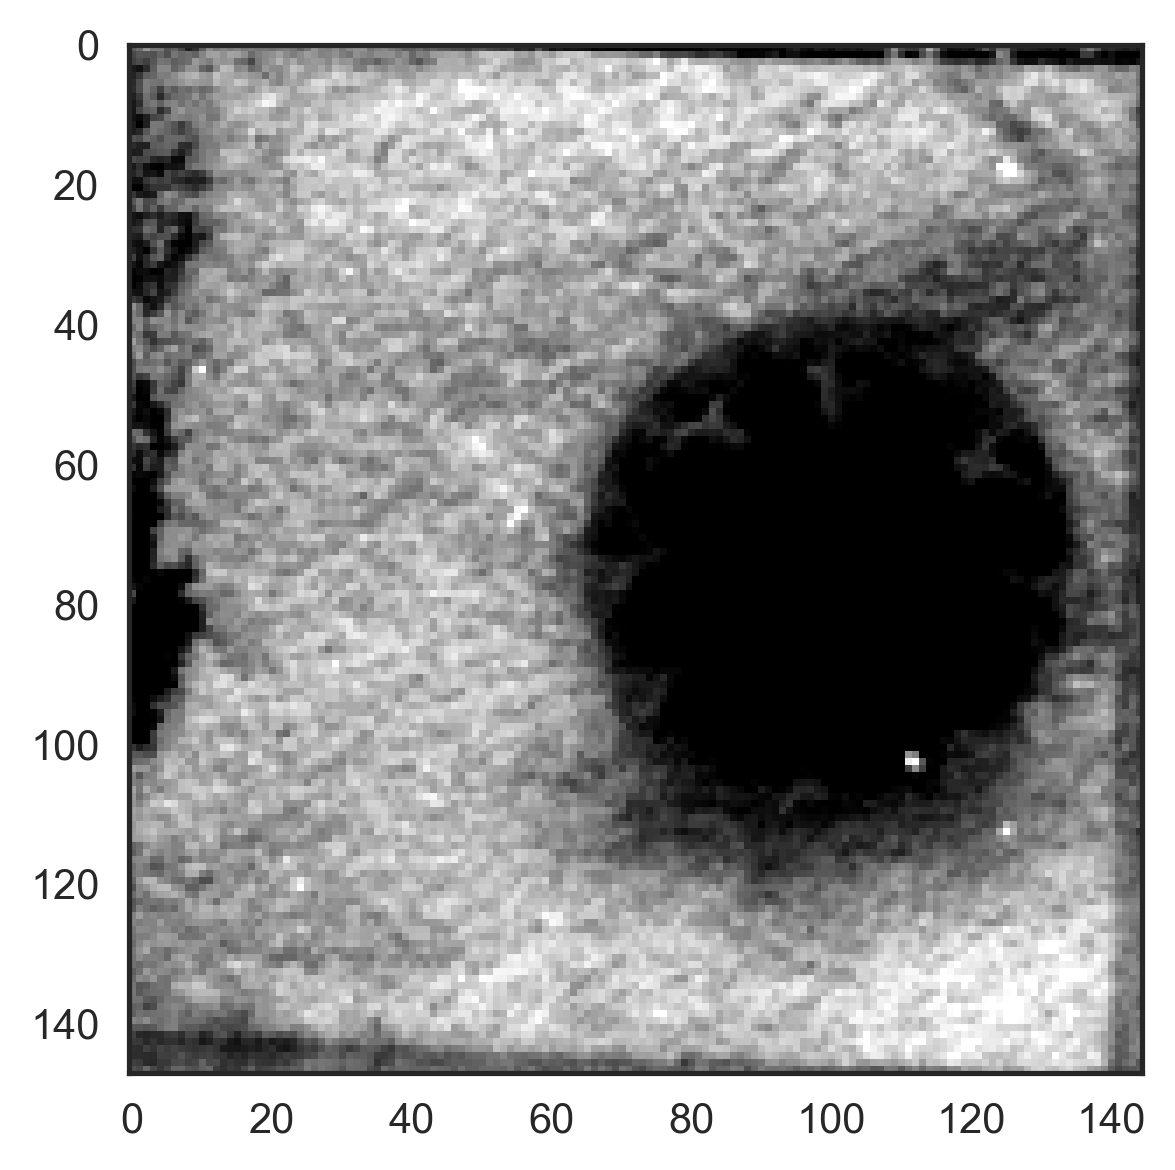

In [45]:
# Define load_func that only gives region bounding ROI
def load_roi(fname, roi_bbox=None, **kwargs):
    """
    Image loading function to only load ROI.
    """
    if roi_bbox is None:
        return skimage.io.imread(fname)[:,:,0]
    else:
        return skimage.io.imread(fname)[:,:,0][roi_bbox]

# Load image collection
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox)

# Look at first image
with sns.axes_style('white'):
    skimage.io.imshow(ic[0])

## Some simple analysis

We are interested in the rate at which the jellyfish pulse.  Since the jellyfish are dark on a black background, we could just watch how the total pixel intensity of our respective ROIs change over time to get the pulsing frequency.  This will not really tell us about the shape of the jellyfish or any fine detail, but it will hopefully be enough to get us a rough estimate of pulsing frequency.

To be more concrete, our goal is to find the distribution of inter-contraction times.  If the distribution is tightly peaked, we have periodic pulsing and we can estimate a frequency.  Otherwise, we might notice pause events that we can see qualitatively in the movies.

We will analyze the jellyfish in our current ROI.  To start with, we'll just compute the total pixel intensity through time.

In [46]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box].sum()

/Users/Justin/anaconda/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


Let's plot the result!

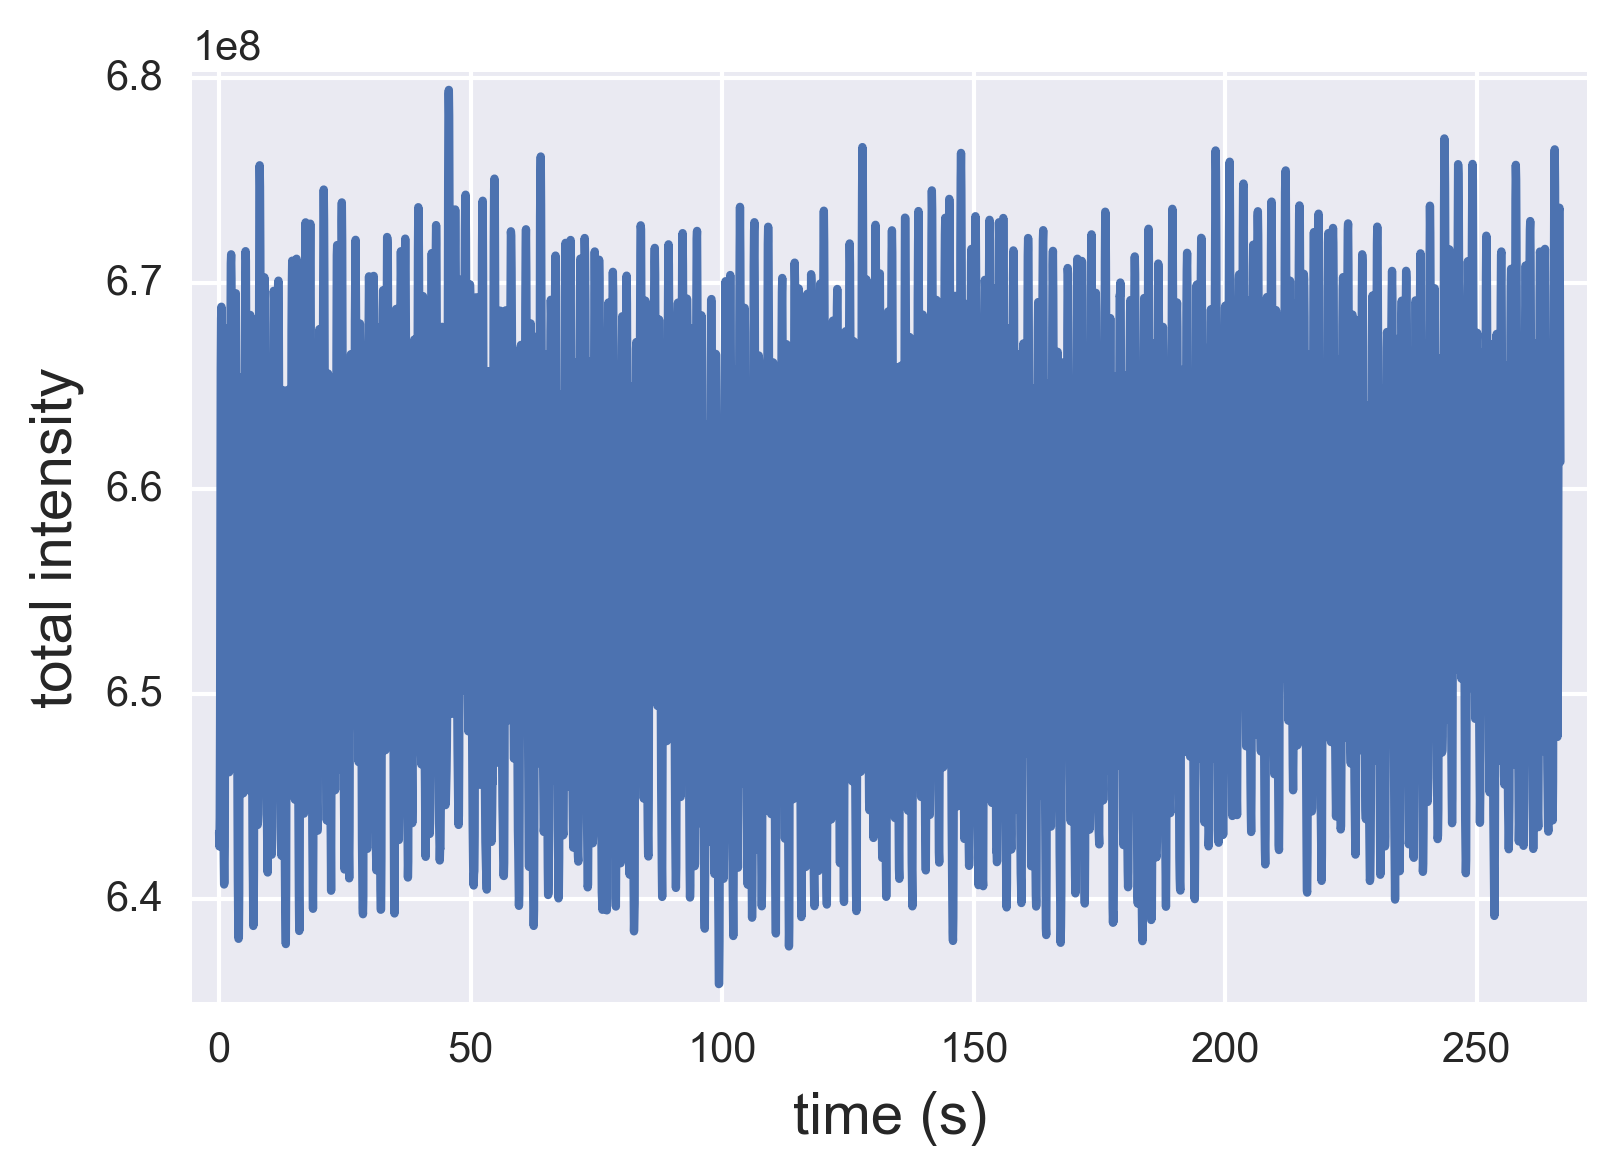

In [47]:
plt.plot(t, total_int)
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

Since the intensity units are arbitrary, we can let's subtract the mean and rescale the data so they go from -1 to 1.

In [48]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

It will be easier to inspect these data by looking at a smaller time window.  We'll look at the 30 seconds.

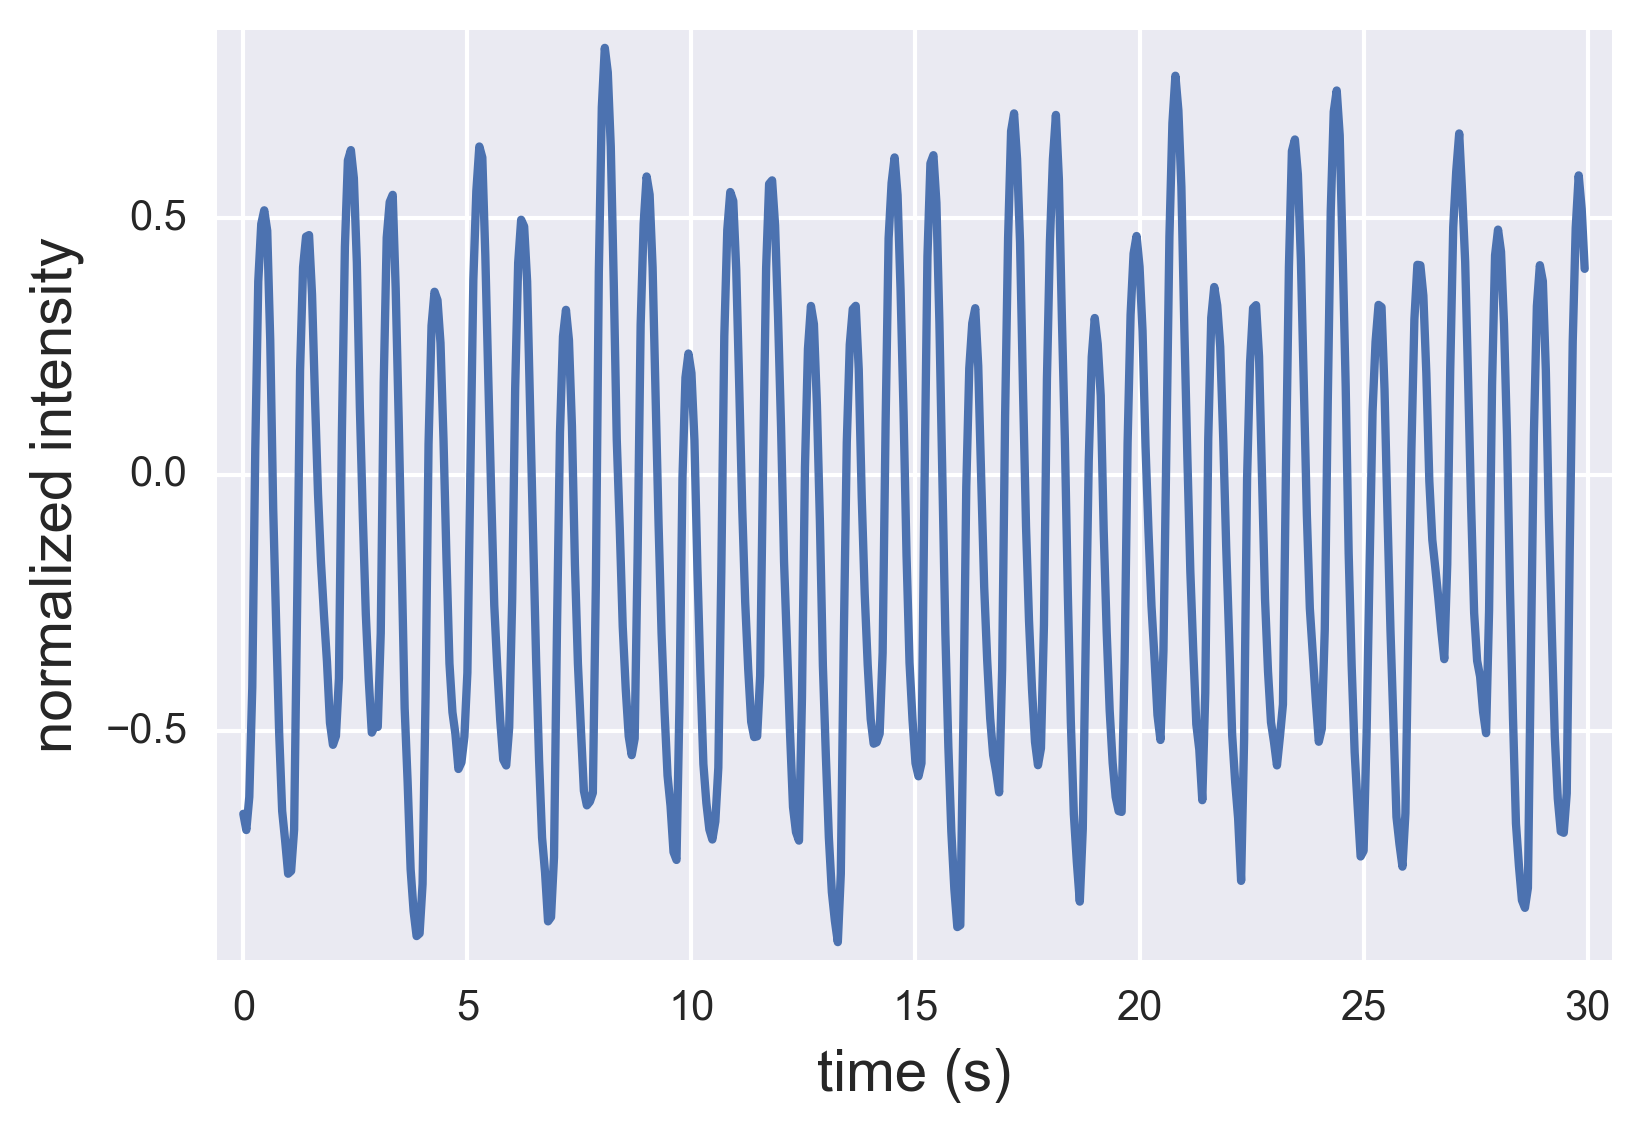

In [49]:
tinds = np.s_[:fps*30]
plt.plot(t[tinds], total_int[tinds])
plt.xlabel('time (s)')
plt.ylabel('normalized intensity')
plt.margins(0.02)

Better yet, we can just plot it with Bokeh.

In [50]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

## Your turn

Can you do the similar analysis with the night time data set and compare the results to the day?  Can you do it for all eight jellyfish? Can you analyze the time series to get the inter-peak intervals?  What do you observe?  This is actually one of your homework problems.